In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
# Display matrices nicely
def displaymat(A,r = 2):
    print(np.round(np.array(A),r))
maxiter = 50

In [4]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        # Set the random state, rank, maxiter, and tol.
        self.random_state = random_state
        self.k = rank
        self.maxiter = maxiter
        self.tol = tol

        # Initialize the W, H, V, and V_r matrices.
        self.W = None
        self.H = None
        self.V = None
        self.V_r = None
        
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        # Set the random seed.
        np.random.seed(self.random_state)

        # Initialize W and H.
        self.W = np.random.rand(m,self.k)
        self.H = np.random.rand(self.k,n)
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        # Store the V matrix get the dimensions of V and initialize W and H.
        self.V = V
        m,n = V.shape
        self.initialize_matrices(m,n)

        # Initialize initial W and H matrices
        W = cp.Variable((m,self.k), nonneg=True)
        H = cp.Variable((self.k,n), nonneg=True)
        
        # Loop through until the stopping criteria are met.
        for i in range(self.maxiter):
            
            # Create the objective function and solve the problem.
            obj = cp.Minimize(cp.norm(V - W@self.H,p = 'fro'))
            prob = cp.Problem(obj)
            prob.solve()

            # Get W0 and update W
            W0 = self.W
            self.W = W.value.copy()

            # Create the objective function and solve the problem.
            obj = cp.Minimize(cp.norm(V - self.W@H,p = 'fro'))
            prob = cp.Problem(obj)
            prob.solve()

            # Get H0 and update H
            H0 = self.H
            self.H = H.value.copy()

            # Check stopping criteria
            if (np.linalg.norm(self.W - W0,'fro') < self.tol) and (np.linalg.norm(self.H - H0,'fro') < self.tol):
                break


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        # Reconstruct the V matrix.
        self.V_r = self.W @ self.H

In [5]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    # Create the NMFRecommender object and fit the V matrix, get W and H.
    nmf = NMFRecommender(rank = 2)
    nmf.fit(V)
    W = nmf.W
    H = nmf.H

    # Get number of people in component 2 greater than in component 1 and return W, H, and k.
    k = np.sum(H[1] > H[0])
    return W, H, k

In [6]:
prob3()

(array([[4.32357340e-01, 1.55958368e+00],
        [7.28830824e-01, 2.67353753e+00],
        [2.59497870e-01, 1.23222299e+00],
        [2.77133682e+00, 7.42173394e-08],
        [2.00262945e-09, 3.68909407e-01]]),
 array([[6.13701977e-08, 7.26310744e-01, 1.07593007e+00, 1.44659281e+00,
         3.52998322e-01, 3.65555244e-01],
        [5.85630624e-01, 7.72185164e-01, 6.58447872e-02, 7.09874825e-09,
         8.03647818e-01, 7.67521958e-01]]),
 4)

In [9]:

#get data
def get_faces(path="./input_files/faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    plt.axis("off")
    
    if plt_show:
        plt.show()

In [10]:
get_faces()

array([[142.198, 158.926, 147.258, ..., 165.182, 114.745, 134.882],
       [143.198, 159.926, 149.258, ..., 164.182, 114.745, 134.882],
       [145.198, 159.926, 151.258, ..., 163.182, 115.745, 133.882],
       ...,
       [100.291,  91.17 ,  87.025, ...,   8.772,  11.729,  46.228],
       [100.291,  92.17 ,  89.025, ...,   8.772,  10.729,  36.228],
       [100.291,  93.17 ,  89.025, ...,   8.772,   9.729,  25.228]],
      dtype=float32)

In [11]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # Get the faces from the faces94 directory and set figure size
    face = get_faces()
    plt.figure(figsize = (12,10))
    error = []
    
    # Initialize rank, alpha, and l1_ratio values.
    n =75
    alpha = [0,0.2,.5]
    l1_ratio = [0,1e-5,1]

    # Loop through all combinations of rank, alpha, and l1_ratio.
    for i,a in enumerate(alpha):
        for j, r in enumerate(l1_ratio):
       
            # Create the NMF object and fit the face.
            nmf = NMF(n_components = n,alpha = a,l1_ratio = r, max_iter = maxiter)

            # Get the W and H matrices and reconstruct the face.
            W = nmf.fit_transform(face)
            H = nmf.components_
            face_r = W @ H[:,2]

            # Get the error
            error.append(np.linalg.norm(face[:,2] - face_r))

            # Plot the original and reconstructed faces and give title
            plt.subplot(3,3,3*i+j+1)
            plt.title("alpha = {},  l1_ratio = {}".format(a,r))

            # Plot the image and make it look nice.
            show(face_r)

    # Get the best parameters
    index = np.argmin(error)
    bestalpha = alpha[index//3]
    bestl1 = l1_ratio[index%3]
    
    # Make the plot look nice and show it
    plt.tight_layout()
    plt.show()

    # Print the best parameters and return them.
    print("The best alpha value is {} and the best l1_ratio value is {}".format(bestalpha,bestl1))
    print("This is the picture with indices ({},{})".format(index//3,index%3))
    return bestalpha, bestl1

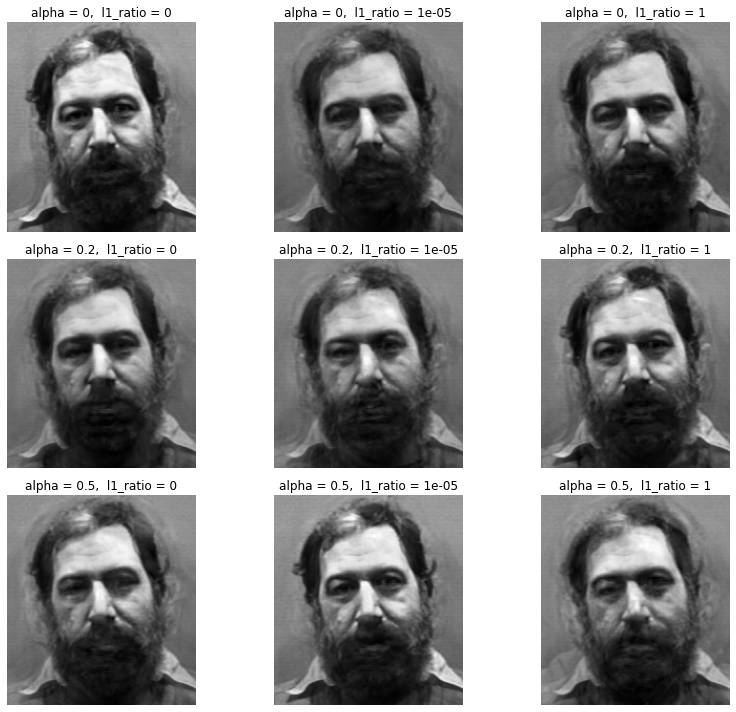

The best alpha value is 0.5 and the best l1_ratio value is 1e-05
This is the picture with indices (2,1)


In [12]:
alpha, l1 = prob4()

In [94]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    # Get the faces and identify second and twelfth face.
    faces = get_faces()
    face2 = faces[:,1]
    face12 = faces[:,11]

    # Create the NMF object and fit the faces.
    nmf = NMF(n_components = 75,alpha = alpha,l1_ratio = l1, max_iter = maxiter)
    W = nmf.fit_transform(faces)
    H = nmf.components_

    # Get the basis faces with the 10 largest coefficients for the second and twelfth face.
    basis2 = np.argsort(H[:,1])[-10:]
    basis12 = np.argsort(H[:,11])[-10:]

    # Plot the original faces and the basis faces.
    plt.figure(figsize = (6,30))
    plt.subplot(11,2,1)
    plt.title("Original Face 2")
    show(face2)

    # Plot the original faces and the basis faces.
    plt.subplot(11,2,2)
    plt.title("Original Face 12")
    show(face12)

    # Loop through all the basis faces for face 2 and plot them.
    for i in range(10):
        plt.subplot(11,2,3+2*i)
        plt.title("Basis Face 2: " + str(i+1))
        show(W[:,basis2[i]])

        # Plot the basis faces for face 12.
        plt.subplot(11,2,4+2*i)
        plt.title("Basis Face 12: " + str(i+1))
        show(W[:,basis12[i]])    

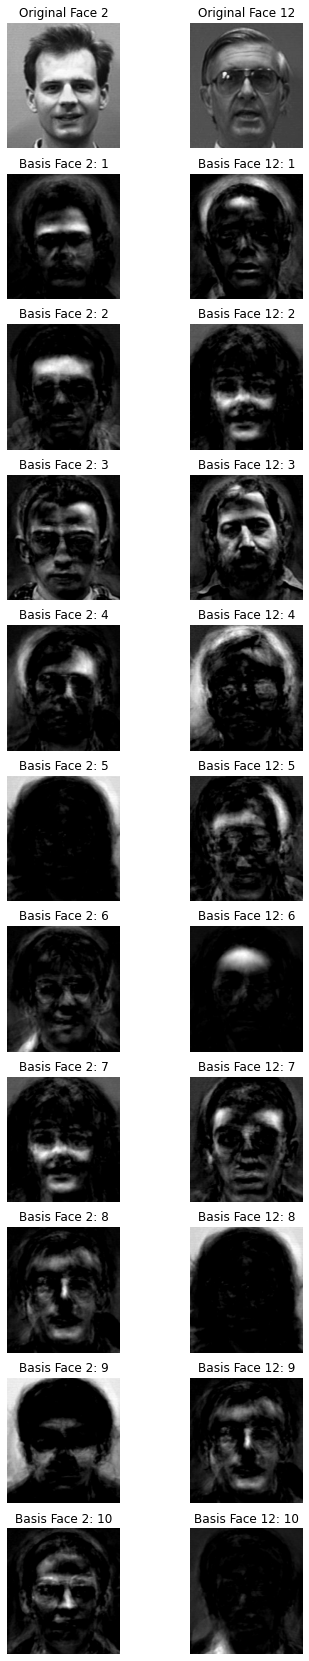

In [95]:
prob5()

We see for face 2, that the guy has a bright forhead, face, and nose, so we see faces with a bright nose, another has a bright forhead, and another with bright cheeks. Also for face 12, He has bright forhead and hair, and so we see that resemblance in basis face with bright hair and bright forhead.